# Multi-Target Tracking in 2D Using Joint Probabilisitic Data Association and Platform Simulation
In the Stone Soup library, simulations can be set up and run using special `FixedPlatform` and `Sensor` objects. Simulated data can be preferable to
real data as the user has more control over the tracking scenario and real
data can be difficult or costly to acquire.


## 1. Imports 
We will begin by importing many relevant packages for the simulation.


In [191]:
from datetime import datetime
from datetime import timedelta
import numpy as np
import random


# Stone Soup imports:
from stonesoup.types.state import State, GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix
from stonesoup.models.transition.linear import (CombinedLinearGaussianTransitionModel, ConstantVelocity)
    
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange

from stonesoup.deleter.time import UpdateTimeStepsDeleter
from stonesoup.tracker.simple import MultiTargetMixtureTracker
from matplotlib import pyplot as plt


# We set the start time to be the moment when we begin the simulation; for
# simulations, the actual time doesn't matter, only the time delta between the
# start and the point in question. We also set a random seed to ensure a
# standard outcome. At the end, you can try changing this value to see how the
# stochastic nature of the simulation and tracker can produce very different
# tracking scenarios with the same parameters.
start_time = datetime.now()
np.random.seed(667)
random.seed(667)

## 2. Initialize the Stationary Platform
In Stone Soup, `Sensor` objects are placed upon simulated platforms.
 
Here, we will create a platform that will hold our radar sensor. In this case, the platform is stationary and located at the point `(0, 0)`, though in general it need not be. If the platform were moving, it would contain position and velocity interleaved: `[x, vx, y, vy, z, vz]`.




In [192]:
# First import the fixed platform
from stonesoup.platform.base import FixedPlatform

# Define the initial platform position, in this case the origin
platform_state_vector = StateVector([[0], [0]]) #State Vector has two dimensions, [x, y]
position_mapping = (0, 1) #Mapping betweem platform position and state vector. 

# Create the initial state (position, time). Notice that the time is set to
# the simulation start time defined earlier
platform_state = State(platform_state_vector, start_time)

# Create our fixed platform
platform = FixedPlatform(
    states=platform_state,
    position_mapping=position_mapping
)

## 3. Initialize the Sensor

Now that our sensor platform has been created, we can create a sensor to
attach to it. In this case, we will be using a radar that takes measurements
of range and bearing of the targets.

In [193]:
from stonesoup.sensor.radar.radar import RadarBearingRange
from stonesoup.models.clutter import ClutterModel

In order to initialize the sensor, first we create a covariance matrix, which is a suitable measurement accuracy
for the radar sensor. This is essentially defines the amount of noise received from the radar.

This radar measures range with an accuracy of +/- 25m, and bearing accuracy of +/- 0.5
degrees.



In [194]:
noise_covar = CovarianceMatrix(np.array(np.diag([np.deg2rad(0.5)**2,
                                                 25**2])))

The radar needs to be informed of where x and y are in the target state
space. In Stone Soup the states are often similar to the form of [x, vx, y, vy]. Thus, the x and y positions would be mapped to indices 0 and 2.  

In [195]:
radar_mapping = (0, 2)

The Stone Soup platform simulation has the ability to
generate clutter directly from the sensors using the `ClutterModel`
class. Using the clutter models, we can simulate realistic clutter
originating from the measurement model. Clutter is defined in the Cartesian
plane and converted to the correct measurement types according to the
sensor. We will now add a clutter model to the radar sensor. This clutter
model will use a uniform distribution over the defined ranges in each
dimension.

In [196]:
params = ((-8000, 8000),  # clutter min x and max x
          (-8000, 8000))  # clutter min y and max y
      
clutter_model = ClutterModel(
     clutter_rate=0.5,
     distribution=np.random.default_rng().uniform,
     dist_params=params
)

# Instantiate the radar
radar = RadarBearingRange(
    ndim_state=4,
    position_mapping=radar_mapping,
    noise_covar=noise_covar,
    clutter_model=clutter_model
)

# And finally, attach the sensor to the stationary platform we defined above.
platform.add_sensor(radar)


## 4. Create the Simulation 
For this example, we wish to have a simulation of multiple airborne targets.
We will use the `MultiTargetGroundTruthSimulator` class to simulate
the target paths, and then the `PlatformDetectionSimulator` class
to handle the radar simulation.

In this example, targets are initiated with values based upon a mean state and a covariance. The initial target state models the following assumptions:
- $x$ is Gaussian distributed around the platform location with variance of $2km$
- $y$ is Gaussian distributed around the platform location with variance of $2km$
- $\dot{x}$ is Gaussian distributed around $100ms^{−1}$ with variance of $50ms^{−1}$ 
- $\dot{y}$ is Gaussian distributed around $100ms^{−1}$ with variance of $50ms^{−1}$ 


In [197]:
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator

# Set a constant velocity transition model for the targets
transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(0.5), ConstantVelocity(0.5)])

# Define the Gaussian State from which new targets are sampled on
# initialisation
initial_target_state = GaussianState(
    state_vector=StateVector([[0], [0], [0], [0]]),
    covar=CovarianceMatrix(np.diag([2000, 50, 2000, 50]))
)

groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,  # target transition model
    initial_state=initial_target_state,  # add our initial state for targets
    timestep=timedelta(seconds=1),  # time between measurements
    number_steps=120,  # 2 minutes
    birth_rate=0.05,  # 5% chance of a new target being born every second
    death_probability=0.05  # 5% chance of a target being killed
)

# With our truth data generated and our sensor platform placed, we can now
# construct a simulator to generate measurements of the targets from each
# of the sensors in the simulation; in this case, just the stationary radar.
from stonesoup.simulator.platform import PlatformDetectionSimulator

sim = PlatformDetectionSimulator(
    groundtruth=groundtruth_sim,
    platforms=[platform]
)

## Set Up the Tracking Algorithm
For this example, we will be using the JPDA algorithm to perform "soft"
associations of the measurements to the targets. This is necessary as we
have multiple airborne targets whose paths may intersect - a "hard" or
"greedy" association algorithm such as the GNN may have issues in these
cases, as when erroneous associations are propagated, the resulting tracking performance can deteriorate rapidly.



In [198]:
# First, we create a Kalman predictor using the transition model from the
# target simulation. In real situations, you may not know the actual
# transition model.
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

# Next, we define a measurement model for the Kalman updater. Here we have
# altered the noise covariance matrix slightly to make it harder for the
# tracker.



meas_covar = np.diag([np.deg2rad(2000), 50]) # Good parameters to play with when tracks are far from 
                                             # the measurements

meas_covar_trk = CovarianceMatrix(1.0*np.power(meas_covar, 2))
meas_model = CartesianToBearingRange(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=meas_covar_trk
)

# Using the measurement model, we make a Kalman updator which we will pass
# into our JPDA tracker.
from stonesoup.updater.kalman import ExtendedKalmanUpdater
updater = ExtendedKalmanUpdater(measurement_model=meas_model)

# The hypothesiser will assume that there is a 95% chance to measure any given
# target at any given timestep. In real life, this probability is based on the
# SNR of the target signals. The clutter spatial density of the hypothesiser
# can be changed to check what happens when there is a mismatch between the
# estimated clutter rate and actual clutter rate.
from stonesoup.hypothesiser.probability import PDAHypothesiser
Pd = 0.95  # 95%
hypothesiser = PDAHypothesiser(predictor=predictor,
                               updater=updater,
                               clutter_spatial_density=0.125,
                               prob_detect=Pd)

# Using the hypothesiser, we can make a data associator. Other MTT algorithms
# may use different association algorithms (like GNN)
from stonesoup.dataassociator.probability import JPDA
data_associator = JPDA(hypothesiser=hypothesiser)

# We implement a simple deleter algorithm to delete tracks if no measurements
# have fallen within the JPDA gating region in 5 time steps.
deleter = UpdateTimeStepsDeleter(time_steps_since_update=5)


We will now set up a track initiator. In real life, targets may enter the
measurement zone at any time during the collection period, and may leave at
any point as well. To distinguish new targets from random clutter, we use a
track initiator. 

This specific algorithm is a multi-measurement initiator;
it utilises features of the tracker to initiate and hold tracks temporarily
within the initiator itself, releasing them to the tracker once there are
multiple detections associated with them enough to determine that they are
"sure" tracks. In this case, the tracks are initiated after 3 appropriate
detections in a row.

In [199]:
from stonesoup.initiator.simple import MultiMeasurementInitiator
from stonesoup.dataassociator.neighbour import NearestNeighbour

""" 
# Pay no attention to that man behind the curtain!  
min_detections = 2 # number of detections required to begin a track
initiator_prior_state = GaussianState(
    state_vector=np.array([[0], [0], [0], [0]]),
    covar=np.diag([0, 50, 0, 50])**2
)
""" 
 
min_detections = 4  # number of detections required to begin a track
initiator_prior_state = GaussianState(
    state_vector=np.array([[0], [0], [0], [0]]),
    covar=np.diag([0, 5, 0, 5])**2 # Good parameter to play with
)

initiator_meas_model = CartesianToBearingRange(
    ndim_state=4,
    mapping=np.array([0, 2]),
    noise_covar=noise_covar
)

initiator = MultiMeasurementInitiator(
    prior_state=initiator_prior_state,
    measurement_model=meas_model,
    deleter=deleter,
    data_associator=NearestNeighbour(hypothesiser),
    updater=updater,
    min_points=min_detections,
    updates_only=True
)

Now we are ready to Create a JPDA multi-target tracker. 

In [200]:
#Try with GMPHD at same time 

JPDA_tracker = MultiTargetMixtureTracker(
    initiator=initiator,
    deleter=deleter,
    detector=sim,
    data_associator=data_associator,
    updater=updater
)

## Run the Simulation and Tracker
Since the JPDA tracker holds the simulation variables, we can easily iterate
through the tracker. Each time it will update the groundtruth simulation,
generate detections using our fixed platform and radar, and run the tracking
algorithm.

In [201]:
# Create lists to hold the information we want to plot later
tracks_plot = set()
tracks_id = set()
groundtruth_plot = set()
detections_plot = set()

# Run the simulation and tracker
for time, ctracks in JPDA_tracker:
    print(time)  # allows us to see the progress of the tracking simulation

    for track in ctracks:
        tracks_plot.add(track)
    for truth in groundtruth_sim.current[1]:
        groundtruth_plot.add(truth)
    for detection in sim.detections:
        detections_plot.add(detection)

2023-07-17 23:03:37.071287
2023-07-17 23:03:38.071287
2023-07-17 23:03:39.071287
2023-07-17 23:03:40.071287
2023-07-17 23:03:41.071287
2023-07-17 23:03:42.071287
2023-07-17 23:03:43.071287
2023-07-17 23:03:44.071287
2023-07-17 23:03:45.071287
2023-07-17 23:03:46.071287
2023-07-17 23:03:47.071287
2023-07-17 23:03:48.071287
2023-07-17 23:03:49.071287
2023-07-17 23:03:50.071287
2023-07-17 23:03:51.071287
2023-07-17 23:03:52.071287
2023-07-17 23:03:53.071287
2023-07-17 23:03:54.071287
2023-07-17 23:03:55.071287
2023-07-17 23:03:56.071287
2023-07-17 23:03:57.071287
2023-07-17 23:03:58.071287
2023-07-17 23:03:59.071287
2023-07-17 23:04:00.071287
2023-07-17 23:04:01.071287
2023-07-17 23:04:02.071287
2023-07-17 23:04:03.071287
2023-07-17 23:04:04.071287
2023-07-17 23:04:05.071287
2023-07-17 23:04:06.071287
2023-07-17 23:04:07.071287
2023-07-17 23:04:08.071287
2023-07-17 23:04:09.071287
2023-07-17 23:04:10.071287
2023-07-17 23:04:11.071287
2023-07-17 23:04:12.071287
2023-07-17 23:04:13.071287
2

## Plot the Results
Now that all of the relevant information has been extracted, the results can
be plotted using the `Plotter` class. 


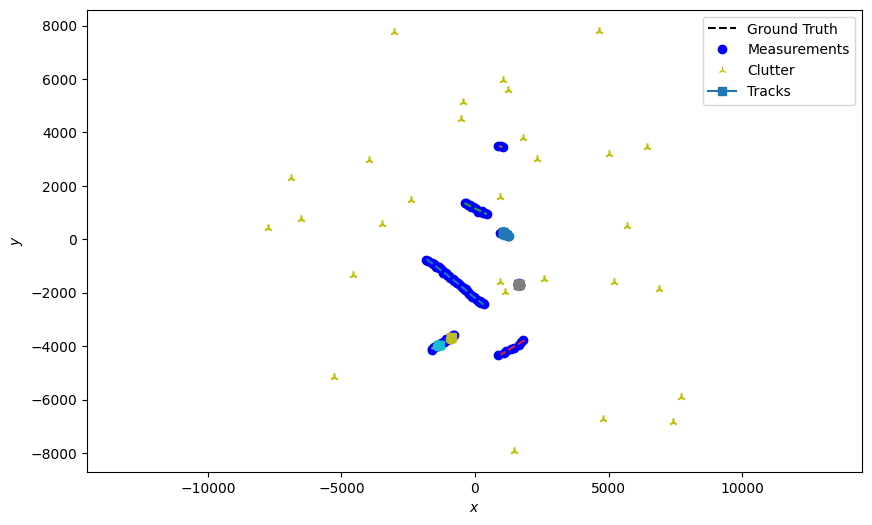

In [202]:
from stonesoup.plotter import Plotter, Dimension
plotter = Plotter()
plotter.plot_ground_truths(groundtruth_plot, [0, 2])
plotter.plot_measurements(detections_plot, [0, 2])
plotter.plot_tracks(tracks_plot, [0, 2], uncertainty=False, err_freq=5)

We also make a second plot without measurements or clutter to better see the tracks.  

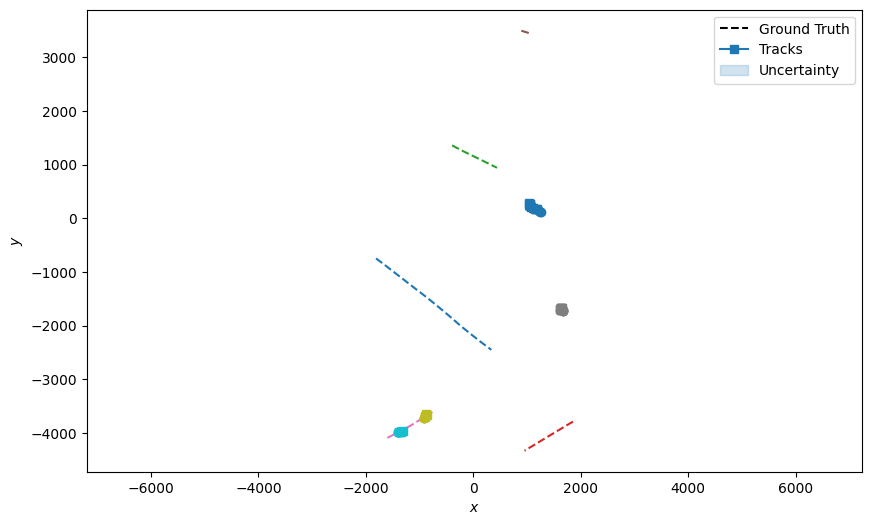

In [203]:
plotter2 = Plotter(Dimension.TWO)
plotter2.plot_ground_truths(groundtruth_plot, [0, 2])
plotter2.plot_tracks(tracks_plot, [0, 2], uncertainty=True, err_freq=5)

## Metrics 

To analyze the tracker performance, we will use the OSPA, SIAP, and
uncertainty metrics. For each of these metrics, we make a generator
object which gets put into a metric manager.

In [204]:
# Imports and Initializations

# OSPA metric
from stonesoup.metricgenerator.ospametric import OSPAMetric
ospa_generator = OSPAMetric(c=40, p=1)

# SIAP metrics
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.measures import Euclidean
SIAPpos_measure = Euclidean(mapping=np.array([0, 2]))
SIAPvel_measure = Euclidean(mapping=np.array([1, 3]))
siap_generator = SIAPMetrics(
    position_measure=SIAPpos_measure,
    velocity_measure=SIAPvel_measure
)

# Uncertainty metric
from stonesoup.metricgenerator.uncertaintymetric import \
    SumofCovarianceNormsMetric
uncertainty_generator = SumofCovarianceNormsMetric()

The metric manager requires us to define an associator. Here we want to
compare the track estimates with the ground truth.

In [205]:
from stonesoup.dataassociator.tracktotrack import TrackToTruth
associator = TrackToTruth(association_threshold=30)

from stonesoup.metricgenerator.manager import SimpleManager
metric_manager = SimpleManager(
    [ospa_generator, siap_generator, uncertainty_generator],
    associator=associator
)

Since we saved the ground truth and tracks above, we can easily add them
to the metric manager now, and then tell it to generate the metrics.

In [206]:
metric_manager.add_data(groundtruth_plot, tracks_plot)
metrics = metric_manager.generate_metrics()

The first metric we will look at is the Optimal Subpattern Assignment (OSPA) metric. It is calculated at each time step, giving an overall multi-track to multi-ground truth missed distance.

Text(0.5, 0, 'Time')

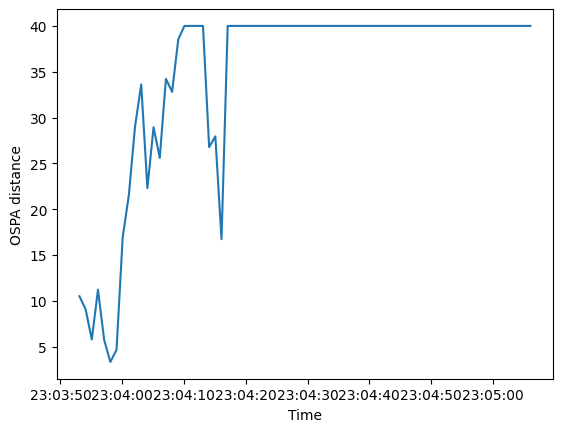

In [207]:
ospa_metric = metrics["OSPA distances"]

fig, ax = plt.subplots()
ax.plot([i.timestamp for i in ospa_metric.value],
        [i.value for i in ospa_metric.value])
ax.set_ylabel("OSPA distance")
ax.set_xlabel("Time")

Next are the Single Integrated Air Picture (SIAP) metrics. Specifically, we will look at the position and
velocity accuracy.

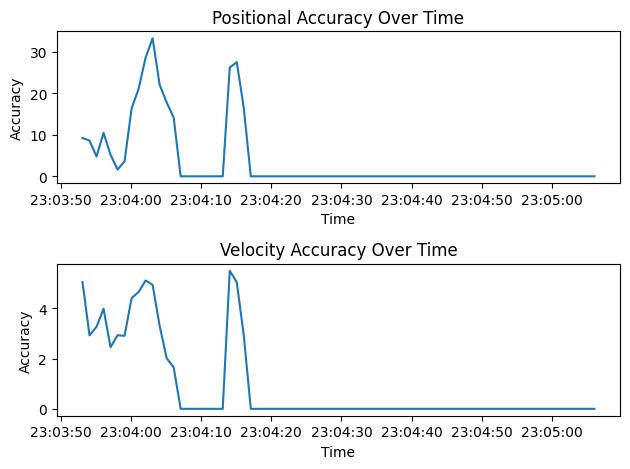

In [208]:
position_accuracy = metrics['SIAP Position Accuracy at times']
velocity_accuracy = metrics['SIAP Velocity Accuracy at times']
times = metric_manager.list_timestamps()

# Make a figure with 2 subplots.
fig, axes = plt.subplots(2)

# The first subplot will show the position accuracy
axes[0].set(title='Positional Accuracy Over Time', xlabel='Time',
            ylabel='Accuracy')
axes[0].plot(times, [metric.value for metric in position_accuracy.value])

# The second subplot will show the velocity accuracy
axes[1].set(title='Velocity Accuracy Over Time', xlabel='Time',
            ylabel='Accuracy')
axes[1].plot(times, [metric.value for metric in velocity_accuracy.value])
plt.tight_layout()

Finally, we will examine a general uncertainty metric. This is calculated as
the sum of the norms of the covariance matrices of each estimated state.
Since the sum is not normalized for the number of estimated states, it is
most important to look at the trends of this graph rather than the values.

Note that uncertainty spikes around the times that tracks for new targets are added, 
and flattens out as these tracks continue to be lain.

[Text(0.5, 1.0, 'Track Uncertainty Over Time'),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Sum of covariance matrix norms')]

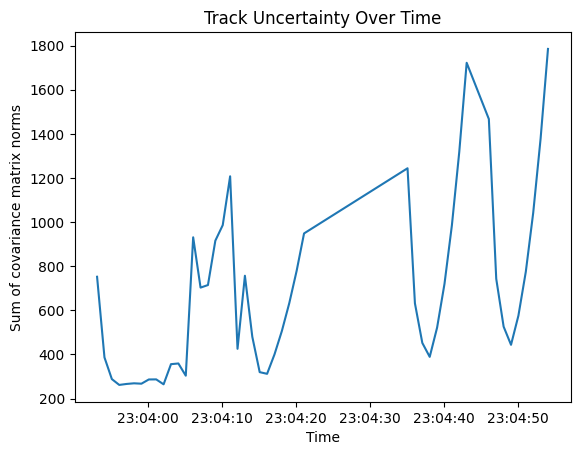

In [209]:
uncertainty_metric = metrics["Sum of Covariance Norms Metric"]

fig, ax = plt.subplots()
ax.plot([i.timestamp for i in uncertainty_metric.value],
        [i.value for i in uncertainty_metric.value])
ax.set(title="Track Uncertainty Over Time", xlabel="Time",
       ylabel="Sum of covariance matrix norms")